In [ ]:
## we saved the dataset in our drive and used it from there itself. Kaggle link is: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/My Drive/WasteClassification/garbage_dataset' '/content'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
DATA_PATH = '/content/garbage_dataset'
MODEL_TYPE = 'efficientnet_b3'
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 25
INIT_LR = 1e-3
L2_REG = 1e-4
DROP_RATE = 0.3
EARLY_STOP_WAIT = 7
LR_REDUCE_WAIT = 3
NUM_CLASSES = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
WORKERS = 4

In [ ]:
from torch.utils.data import random_split

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.2),
    transforms.ColorJitter(.2,.2,.2,.1),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(0.2)
])

eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_train_data = datasets.ImageFolder(f"{DATA_PATH}/waste_dataset_train")

class_names = full_train_data.classes
print("Total classes in dataset:", class_names)

## we had already divided the dataset into test and train in a different file, so here we make the validation set from the train set. 10% validation, 20% test, 70% train.
train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

train_data.dataset.transform = train_transform
val_data.dataset.transform = eval_transform

test_data = datasets.ImageFolder(f"{DATA_PATH}/waste_dataset_test", eval_transform)

train_labels = [full_train_data.targets[i] for i in train_data.indices]
class_counts = np.bincount(train_labels)
weights = 1.0 / (class_counts + 1e-5)
sample_weights = [weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler, num_workers=WORKERS)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

print(f"No of Training samples: {len(train_data)}")
print(f"No of Validation samples: {len(val_data)}")
print(f"No of Test samples: {len(test_data)}")


Total classes in dataset: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
No of Training samples: 9927
No of Validation samples: 2482
No of Test samples: 3106


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
if MODEL_TYPE == "efficientnet_b3":
    net = models.efficientnet_b3(weights="IMAGENET1K_V1")
    in_f = net.classifier[1].in_features
    net.classifier = nn.Sequential(nn.Dropout(DROP_RATE), nn.Linear(in_f, NUM_CLASSES))

elif MODEL_TYPE == "efficientnet_b4":
    net = models.efficientnet_b4(weights="IMAGENET1K_V1")
    in_f = net.classifier[1].in_features
    net.classifier = nn.Sequential(nn.Dropout(DROP_RATE), nn.Linear(in_f, NUM_CLASSES))

else:
    net = models.resnet50(weights="IMAGENET1K_V2")
    in_f = net.fc.in_features
    net.fc = nn.Sequential(nn.Dropout(DROP_RATE), nn.Linear(in_f, NUM_CLASSES))

for param in net.parameters():
    param.requires_grad = False

for param in net.classifier.parameters():
    param.requires_grad = True

net.to(DEVICE)
print("Model type:", MODEL_TYPE)



Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 183MB/s]


Model type: efficientnet_b3


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, net.parameters()),
    lr=INIT_LR,
    weight_decay=L2_REG
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=LR_REDUCE_WAIT
)

In [ ]:
import os
save_dir = "/content/drive/MyDrive/WasteClassification"
os.makedirs(save_dir, exist_ok=True)

best_model_path = f"{save_dir}/best_model.pth"

best_acc = 0
patience = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Training Started...")

for epoch in range(EPOCHS):
    net.train()
    total, correct, epoch_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = net(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(train_acc)

    net.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = net(imgs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            correct += outputs.argmax(1).eq(labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"- Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(net.state_dict(), best_model_path)
        print("🔥 Best model updated and saved!")

    else:
        patience += 1
        if patience >= EARLY_STOP_WAIT:
            print("⛔ Early stopping triggered!")
            break

print(f"\n✅ Training complete! Best Validation Accuracy: {best_acc:.2f}%")
print(f"📌 Best model saved at: {best_model_path}")



Training Started...
Epoch [1/25] - Train Acc: 80.15% | Val Acc: 92.18%
🔥 Best model updated and saved!
Epoch [2/25] - Train Acc: 88.93% | Val Acc: 92.55%
🔥 Best model updated and saved!
Epoch [3/25] - Train Acc: 90.17% | Val Acc: 93.03%
🔥 Best model updated and saved!
Epoch [4/25] - Train Acc: 91.15% | Val Acc: 93.47%
🔥 Best model updated and saved!
Epoch [5/25] - Train Acc: 91.81% | Val Acc: 93.27%
Epoch [6/25] - Train Acc: 91.96% | Val Acc: 93.67%
🔥 Best model updated and saved!
Epoch [7/25] - Train Acc: 92.46% | Val Acc: 93.84%
🔥 Best model updated and saved!
Epoch [8/25] - Train Acc: 93.10% | Val Acc: 94.20%
🔥 Best model updated and saved!
Epoch [9/25] - Train Acc: 92.93% | Val Acc: 93.39%
Epoch [10/25] - Train Acc: 93.30% | Val Acc: 94.08%
Epoch [11/25] - Train Acc: 93.41% | Val Acc: 93.43%
Epoch [12/25] - Train Acc: 93.37% | Val Acc: 93.35%
Epoch [13/25] - Train Acc: 93.47% | Val Acc: 94.16%
Epoch [14/25] - Train Acc: 93.68% | Val Acc: 94.48%
🔥 Best model updated and saved!
Epoch

In [ ]:
net.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
net.to(DEVICE)
net.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
test_loss, correct, total = 0, 0, 0

net.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = net(imgs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"🧪 Test Accuracy: {test_acc:.2f}%")
print(f"🧪 Test Loss: {test_loss / len(test_loader):.4f}")



🧪 Test Accuracy: 95.30%
🧪 Test Loss: 1.2803


In [ ]:
def collect_predictions(model, data_loader):
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            preds.extend(outputs.argmax(1).cpu().numpy())
            labels.extend(lbls.numpy())
    return np.array(preds), np.array(labels)

y_pred, y_true = collect_predictions(net, test_loader)


In [ ]:
print("FINAL Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


FINAL Classification Report:
              precision    recall  f1-score   support

     battery       0.95      0.97      0.96       189
  biological       0.95      0.97      0.96       197
 brown-glass       0.91      0.96      0.94       122
   cardboard       0.97      0.95      0.96       179
     clothes       1.00      0.98      0.99      1065
 green-glass       0.98      0.94      0.96       126
       metal       0.85      0.88      0.87       154
       paper       0.92      0.92      0.92       210
     plastic       0.88      0.87      0.88       173
       shoes       0.96      0.97      0.97       396
       trash       0.93      0.96      0.94       140
 white-glass       0.89      0.87      0.88       155

    accuracy                           0.95      3106
   macro avg       0.93      0.94      0.93      3106
weighted avg       0.95      0.95      0.95      3106



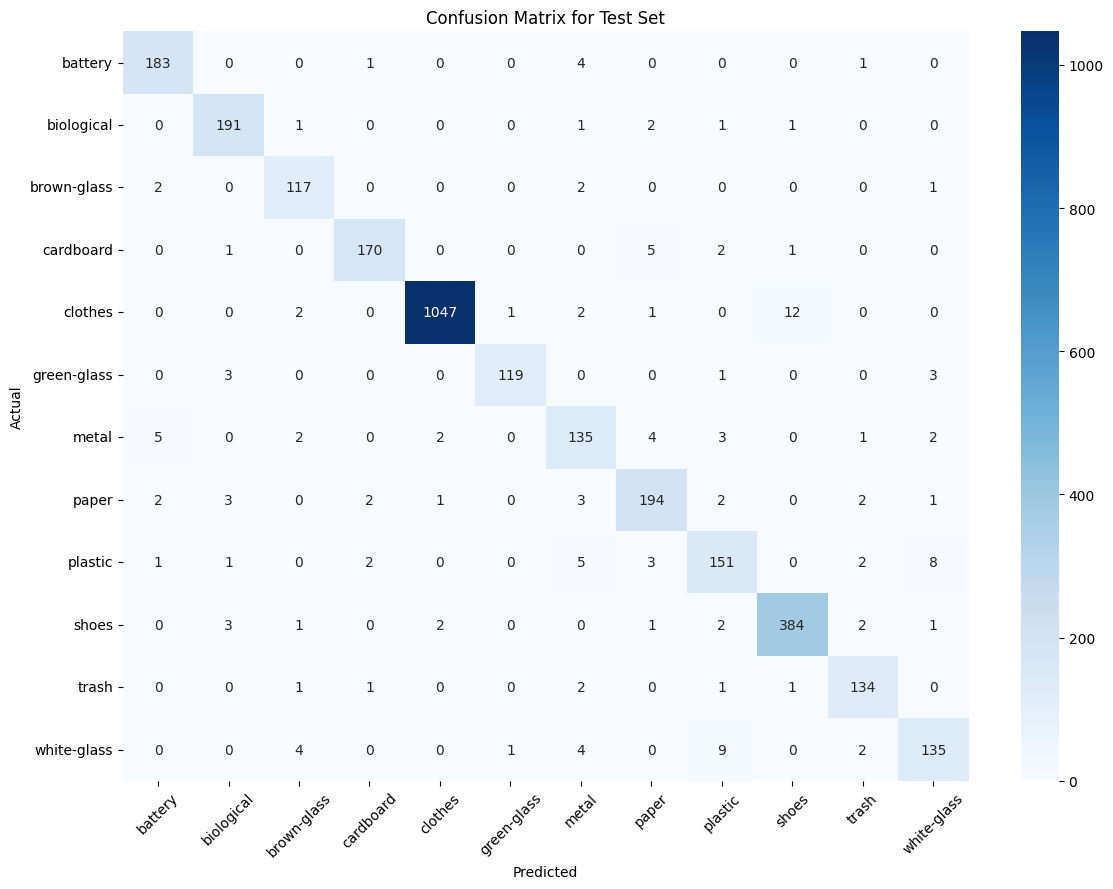

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

cm_path = f"{save_dir}/confusion_matrix.png"
plt.tight_layout()
plt.savefig(cm_path, dpi=300)
plt.show()

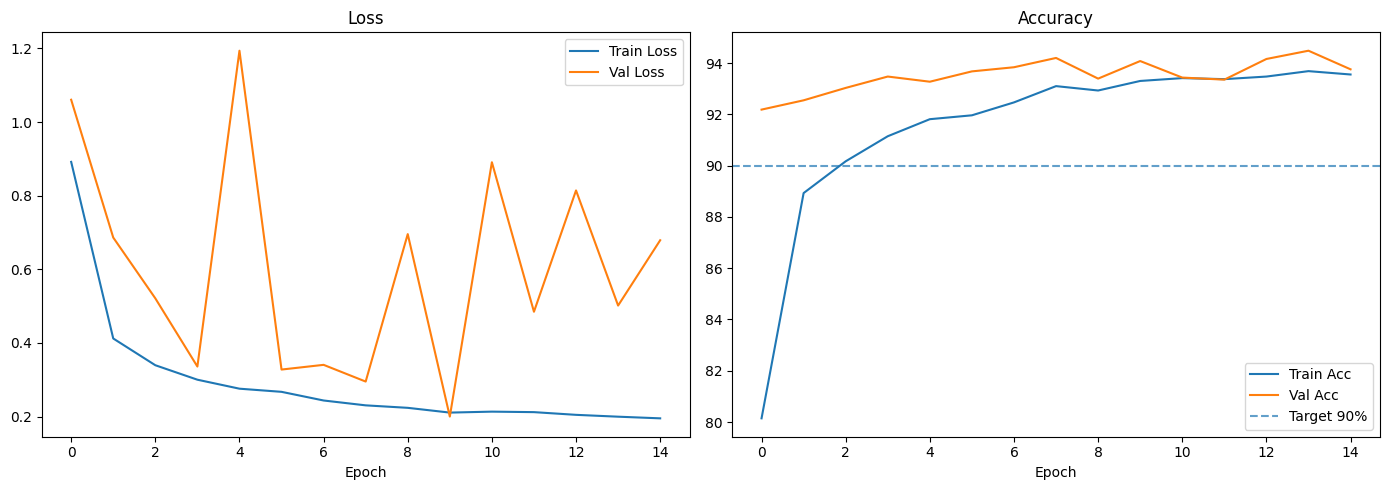

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.axhline(90, linestyle="--", alpha=0.7, label="Target 90%")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plot_path = f"{save_dir}/training_curves.png"
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()


In [ ]:
from google.colab import files
from PIL import Image

uploaded = files.upload()

uploaded_image_path = None
for fname in uploaded.keys():
    uploaded_image_path = fname
    print(f"current uploaded file: {fname}")


Saving biological126.jpg to biological126.jpg
current uploaded file: biological126.jpg


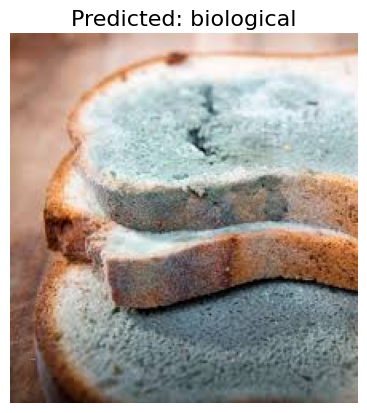

In [ ]:
img = Image.open(uploaded_image_path).convert("RGB")
transform = eval_transform
img_t = transform(img).unsqueeze(0).to(DEVICE)

net.eval()
with torch.no_grad():
    output = net(img_t)
    pred_class = output.argmax(1).item()

pred_label = class_names[pred_class]

plt.imshow(img)
plt.title(f"Predicted: {pred_label}", fontsize=16)
plt.axis("off")
plt.show()
